In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from time import time
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# ---
pd.set_option('display.max_columns', 150)
sns.set()
# ---

def clean_text(text):
    """
    Custom function to clean text from social media or political speeches.
    """
    # Text preprocessing: 
    # 1) Extract the text and transform it into lowercase
    clean_text = text.lower()
    
    # 2) Removing punctuation to get the transformed frequency properly after 
    # splitting by white spaces
    clean_text = re.sub(r'[^\w\s#@]', '', clean_text)
    
    # 3) Remove links from the raw text to avoid counting it as an additional word:
    clean_text = re.sub(r'https\w+', '', clean_text)
    
    # 4) Remove remaining whitespaces:
    clean_text = clean_text.strip()
    
    # 5) Transform more than two spaces, newlines and tabs into just one space:
    clean_text = re.sub(r'\s{2,}|\n|\t', ' ', clean_text)
    
    return clean_text

def compare_diffs_plot(dataframe, text_type, figheight = 8,
                       relative = True, word_freq = 100, return_dataset = False,
                       save_fig = False):
    """
    Get a dataframe with counts of moral values and each word, and generate 
    a plot of the differences in frequencies of use of moral foundations.
    ---
    dataframe: pd.DataFrame; The pandas DataFrame of counts to be used
    text_type: str; either "tweets" or "speeches". Used for the plot
    figheight: int; set figure height
    relative: bool; if True, it displays relative frequencies
    word_freq: int; if the measures are relative, it determines the frequency
        (e.g., per 1000 words if word_freq = 1000)
    return_dataset: bool; returns the dataset with the grouped foundations
    save_fig: bool; saves the figure
    """
    
    # Create a grouped moral foundation (both vice and virtue word counts are included)
    grouped_foundations_df = dataframe.copy()

    # Create a grouped moral foundation (both vice and virtue word counts are included)
    foundations = list(mfd_dict_esp.keys())
    core_foundations = []
    for foundation_vv in foundations:
        foundation = foundation_vv.split(".")[0]
        if foundation not in core_foundations:
            core_foundations.append(foundation)
        if foundation in grouped_foundations_df.columns:
            grouped_foundations_df[foundation] += grouped_foundations_df[foundation_vv]
        else:
            grouped_foundations_df[foundation] = grouped_foundations_df[foundation_vv]
    
    # We reorder the foundations to create a properly ordered plot:
    reordered_foundations = core_foundations[::-1]
    
    # Create a long dataframe to plot differences between parties:
    diff_df = grouped_foundations_df[["party", "n_words"] + reordered_foundations].copy()
    
    # Optional: Control for the length of each audio (i.e., compare relative frequencies)
    if relative:
        diff_df[reordered_foundations] = diff_df[reordered_foundations].apply(lambda x: x / (2 * diff_df["n_words"]))
        
        # Show the count per frequency of words (like per 1000 words):
        diff_df[reordered_foundations] = diff_df[reordered_foundations] * word_freq
        
    diff_df = diff_df.drop(["n_words"], axis = 1)
    
    # Return the dataset instead of a plot if that was specified
    if return_dataset:
        return diff_df
    
    # Turn the dataframe into a long format:
    diff_long = pd.melt(diff_df, id_vars = "party", value_vars = reordered_foundations)
    
    # Capitalize variable names for the legend:
    diff_long.variable = diff_long.variable.str.capitalize()
    
    # Generate plot:
    sns.set_style("whitegrid")
    font = {'family' : 'serif'}
    plt.rc('font', **font)
    
    # plt.show()
    g = sns.relplot(x = "party", y = "value", style = "variable", hue = "variable", 
                    kind = "line", palette = "gist_ncar", 
                    height = figheight, aspect = 1.5, data = diff_long.iloc[::-1])
    
    if relative:
        title = f"Relative mentions of moral foundations per party - {text_type.capitalize()}"
    else:
        title = f"Mentions of moral foundations per party - {text_type.capitalize()}"
        
    plt.title(title, size = 18, fontweight = "bold")
        
    plt.xlabel("Party", size = 15)
    if relative:
        plt.ylabel(f"Average mentions of each foundation per {word_freq} words", size = 15)
    else:
        plt.ylabel("Average mentions of each foundation per text", size = 15)
    
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    
    new_title = "Foundation"
    g._legend.set_title(new_title)
    
    
    plt.setp(g._legend.get_title(), fontsize = 12)
    plt.setp(g._legend.get_texts(), fontsize = 12)
    
    txt = "Source: Author's own elaboration\nwith data collected through the Twitter API"
    plt.figtext(0.6, -0.02, txt, wrap = True,
                horizontalalignment = 'left', fontsize = 11)
    
    plt.show();
    
    # Save figure
    if save_fig:
        g.savefig(f"plots/all_foundations_{text_type}.jpeg")
    
def clean_rows(rows):
    """
    Cleans rows so that parties are ordered in the Tukey intervals plots from right
    to left.
    """

    rows_to_reverse = [8, 3, 9, 6, 1, 4, 5]
    custom_order = [6, 9, 3, 8, 4, 7, 1, 0, 2, 5]
    

    def reverse_row(row):
        """
        Reverses the order and signs of a row in the Tukey interval.
        """
        new_row = []
        
        # Switch party names order:
        new_row.append(row[1])
        new_row.append(row[0])
        
        # Append mean diff, lower and upper with negative signs:
        new_row.append(- row[2])
        new_row.append(row[3])
        
        # Swap order of upper and lower after switching their signs:
        new_row.append(- row[5])
        new_row.append(- row[4])
        
        return new_row

    rows = [reverse_row(rows[row_id]) if row_id in rows_to_reverse else rows[row_id] for row_id in range(len(rows))]
    rows = [rows[row_order] for row_order in custom_order]
    
    return rows

In [2]:
# Load moral foundations dictionary in Spanish:
with open("dictionaries/final_mfd_dict_stems.pickle", "rb") as handle:
    mfd_dict_esp = pickle.load(handle)

# ANALYSIS OF MORAL FOUNDATIONS IN POLITICAL SPEECHES

## 1 - LOAD DATASET

In [3]:
transcriptions_df = pd.read_csv("../data/clean/transcriptions_df.csv")

## 2 - EDA

In [4]:
print("The number of audios per party is:\n", transcriptions_df.party.value_counts())

The number of audios per party is:
 PP         276
CS         170
PODEMOS    138
PSOE        93
VOX         80
Name: party, dtype: int64


## 3 - APPLY THE DICTIONARY AND ANALYZE THE AUDIOS

In [5]:
moral_df = transcriptions_df.loc[:, ["status_id", "party", 
                                     "screen_name", "transcription"]].copy()

In [6]:
start_time = time()

# Initialize all columns with zeros (start with foundations):
for foundation in mfd_dict_esp:
        moral_df[foundation] = 0
        
for words in mfd_dict_esp.values():
    for word in words:
        moral_df[word] = 0
        
# Clean text: 
moral_df["clean_transcription"] = moral_df.transcription.apply(lambda x: clean_text(x))

# Count the number of words on the clean text
moral_df["n_words"] = moral_df.clean_transcription.apply(lambda x: int(len(x.split(" "))))

# Loop: Count words belonging to the dictionary in each text:
for row in range(moral_df.shape[0]):
    
    clean_text = moral_df.loc[row, "clean_transcription"]
        
    # Loop through all words to count the number of instances in which they appear
    for foundation, words in mfd_dict_esp.items():
        
        for word in words:
            n_matches = moral_df.loc[row, word]
            
            # See if the word has not appared yet in the search
            # (to avoid counting twice the same word)
            if moral_df.loc[row, word] == 0:
                # We perform a regex search of our word on the text and 
                # add the number of words that matched
                n_matches = len(re.findall(word, clean_text))
                moral_df.loc[row, word] = n_matches

            moral_df.loc[row, foundation] += n_matches
            
    if row % 100 == 0:
        print(f'{row} / {moral_df.shape[0]}')

print(f'{time() - start_time} seconds of execution.')

0 / 757
100 / 757
200 / 757
300 / 757
400 / 757
500 / 757
600 / 757
700 / 757
482.4832429885864 seconds of execution.


In [44]:
# Save the counts dataframe
#moral_df.to_csv("../data/clean/counts_transcription.csv", index = False)

## 4 - COMPARE DIFFERENCES BETWEEN GROUPS

In [3]:
moral_df = pd.read_csv("../data/clean/counts_transcription.csv")

- Graphical differences using standard deviations:

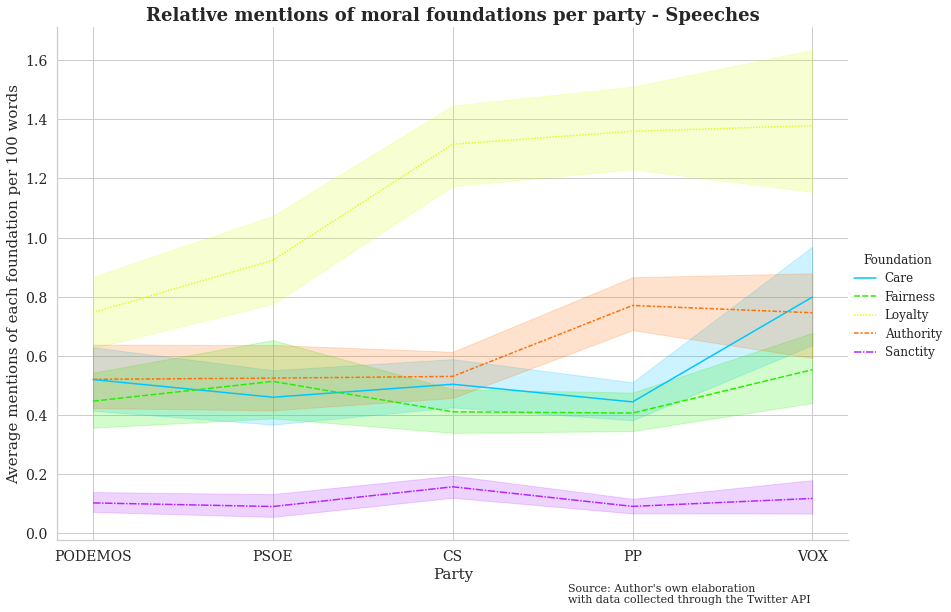

In [7]:
# Plot and save figure
compare_diffs_plot(moral_df, "speeches", save_fig = True)

Results are not sensitive to the elimination of certain common words, the patterns are the same (even if the standard deviations might change a lot).

- Tukey intervals

Check sensitivity of the Tukey interval diffferences to the exclusion of dangerous words

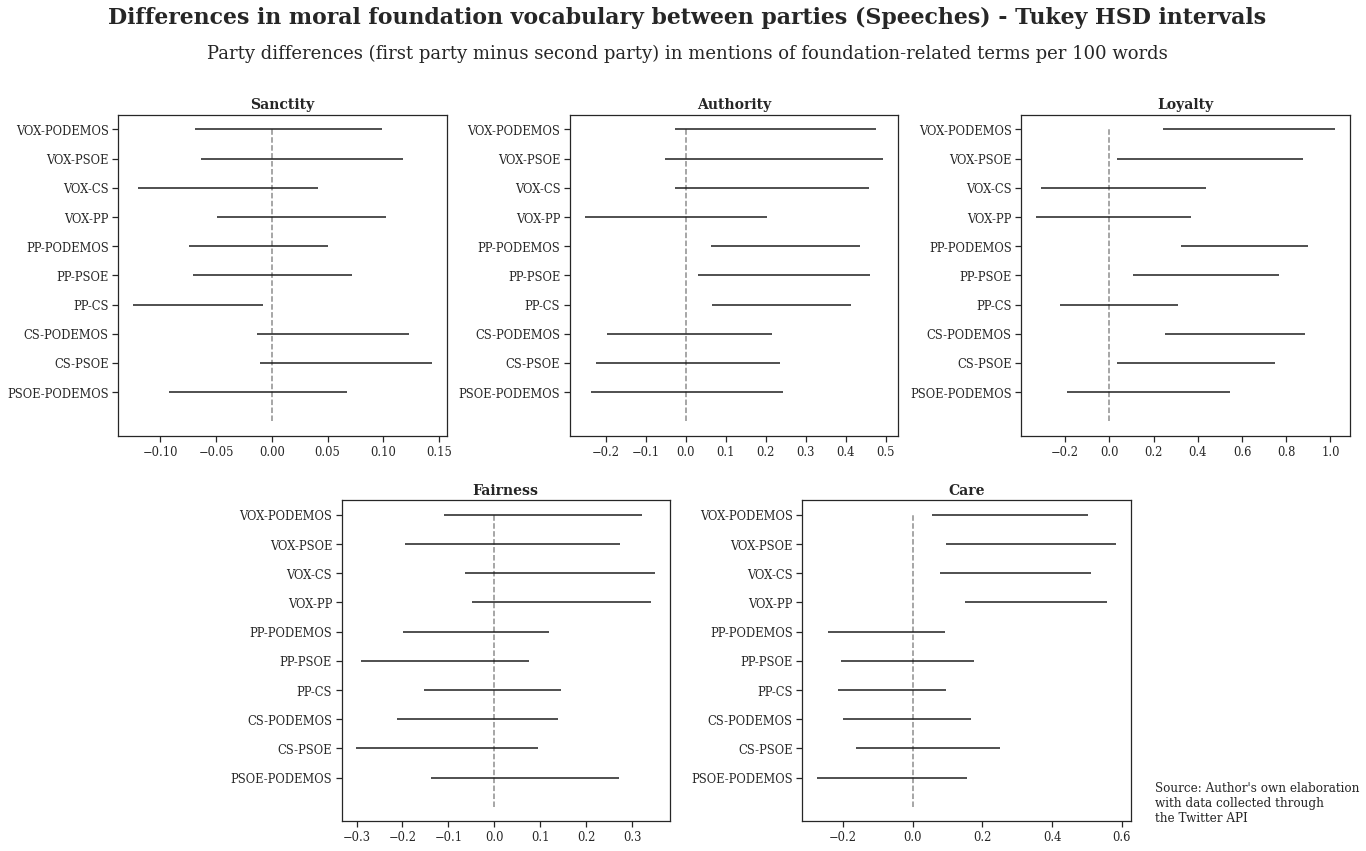

In [25]:
sns.set_style("ticks")
font = {'family' : 'serif'}
plt.rc('font', **font)

core_foundations = ['sanctity', 'authority', 'loyalty', 'fairness', 'care']
foundations_df = compare_diffs_plot(moral_df, "speeches", return_dataset = True)

fig, axes = plt.subplots(2, 3, sharex = False, sharey = False, figsize = (20, 13))

text_type = "speeches"

# Create subplots only for 5 plots, eliminate the 6th one:
axes[1][2].set_visible(False)

go_right = 0.04
go_left = 0.02
go_up = -0.02

axes[0][0].set_position([0.125 - go_left, 0.5368181818181819 + go_up, 0.228, 0.343])
axes[0][1].set_position([0.3985294117647059 + go_right - go_left, 0.5368181818181819 + go_up,0.228,0.343])
axes[0][2].set_position([0.6720588235294118 + (go_right * 2) - go_left, 0.5368181818181819 + go_up,0.228,0.343])
axes[1][0].set_position([0.24 + go_right - go_left, 0.125 + go_up, 0.228, 0.343])
axes[1][1].set_position([0.56 + go_right - go_left, 0.125 + go_up, 0.228, 0.343])

# Set title and subtitle:
fig.text(s = f'Differences in moral foundation vocabulary between parties ({text_type.capitalize()}) - Tukey HSD intervals\n',
         x = 0.5, y = 0.95, fontsize = 22, ha = 'center', va = 'center', fontweight = "bold")

fig.text(s = 'Party differences (first party minus second party) in mentions of foundation-related terms per 100 words', x = 0.5, y = 0.925,
         fontsize = 18, ha = 'center', va = 'center')

for found_id in range(len(core_foundations)):
    col_nr = found_id
    # Determine the ax to plot
    if found_id <= 2:
        ax = axes[0][found_id]
        
    else:
        ax = axes[1][found_id - 3]
        
    # Calculate Tukey differences between groups and plot them
    foundation = core_foundations[found_id]
    tukey_comp = pairwise_tukeyhsd(endog  = foundations_df[foundation], 
                                   groups = foundations_df["party"],
                                   alpha  = 0.05)
    rows = clean_rows(tukey_comp.summary().data[1:])[::-1]
    ax.set_title(f'{foundation.capitalize()}', loc = 'center', 
                 fontsize = 14, fontweight = "bold")
    ax.hlines(range(len(rows)), [-row[5] for row in rows], [-row[4] for row in rows], color = 'k')
    ax.vlines(0, - 1, len(rows) - 1, linestyles = 'dashed', color = 'k', alpha = 0.5)
    
    # Format axes
    ax.set_yticks(range(len(rows)))
    ax.set_yticklabels([f'{x[0]}-{x[1]}' for x in rows])
    ax.xaxis.set_label(f'{foundation.capitalize()} mentions per 100 words')
    
    ax.yaxis.set_tick_params(labelsize = 11.5)
    ax.xaxis.set_tick_params(labelsize = 11.5)
    
# Set caption:
txt = "Source: Author's own elaboration\nwith data collected through\nthe Twitter API"
fig.text(0.825, 0.125, txt, fontsize = 12,
         ha = 'left', va = 'center')
    

    
plt.show();

fig.savefig(f'plots/tukey_intervals_{text_type}.jpeg')


### CHECK SENSITIVITY OF THE RESULTS:

- Check for sensitive words (graphical level with standard deviations):

In [16]:
# Here we create a function that generates the same dataframe, excluding the stem
# (or words) that we have inputted. It allows to make sensitivity checks:
low_sensitive_words = [r"\blegal", r"\bcoali", r"\bsegur"]

doubtful_meaning = [r"\bluch"]

highly_sensitive_words = [r"\bespañ", r"\bconstituci", r"\bpaís", r"\bpact"]



In [17]:
sens_words = low_sensitive_words + doubtful_meaning + highly_sensitive_words

new_df = moral_df.copy()
eliminations = {}
for word in sens_words:
    eliminations[word] = []
    
    # Find in which foundations it appears:
    for foundation, terms in mfd_dict_esp.items():
        if word in terms:
            eliminations[word].append(foundation)
            
            print(foundation)
            
    # Finally, substract those values from the foundations to which it belongs:
    for foundation in eliminations[word]:
        new_df[foundation] -= new_df[word]
    new_df.drop([word], axis = 1)

fairness.virtue
loyalty.virtue
care.virtue
care.vice
loyalty.virtue
fairness.virtue
authority.virtue
loyalty.virtue
authority.virtue


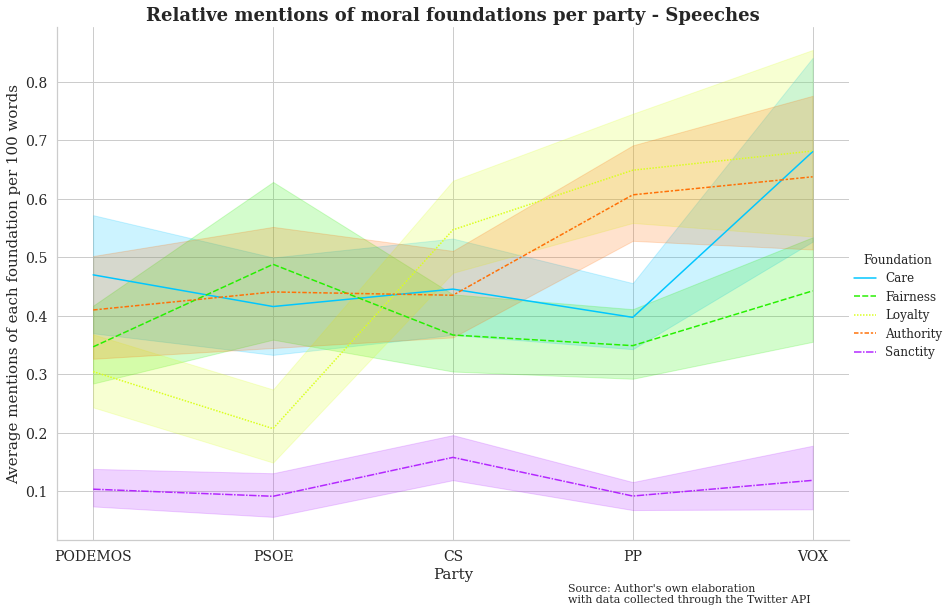

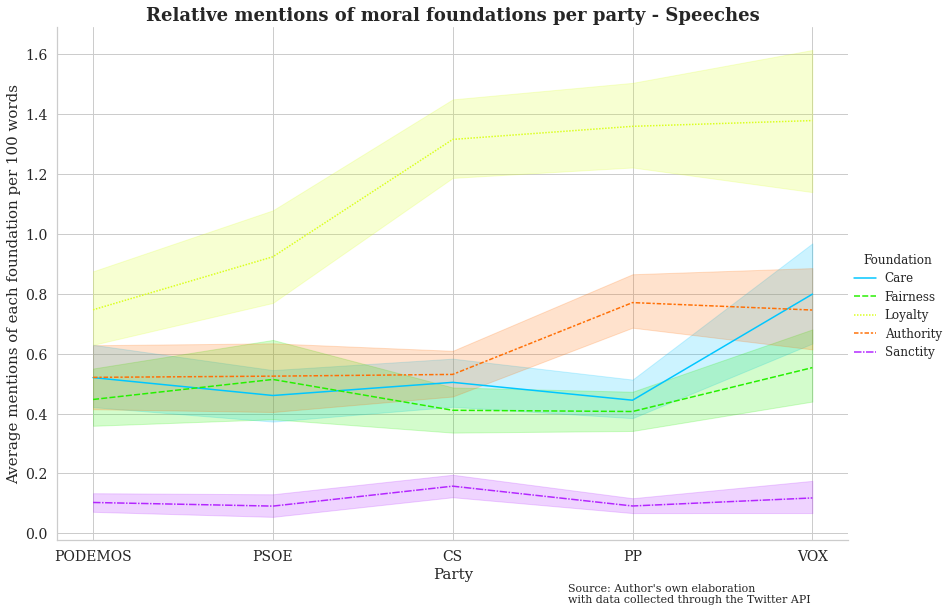

In [18]:
compare_diffs_plot(new_df, "speeches")
compare_diffs_plot(moral_df, "speeches")

- Check sensitivity of the results with Tukey intervals:

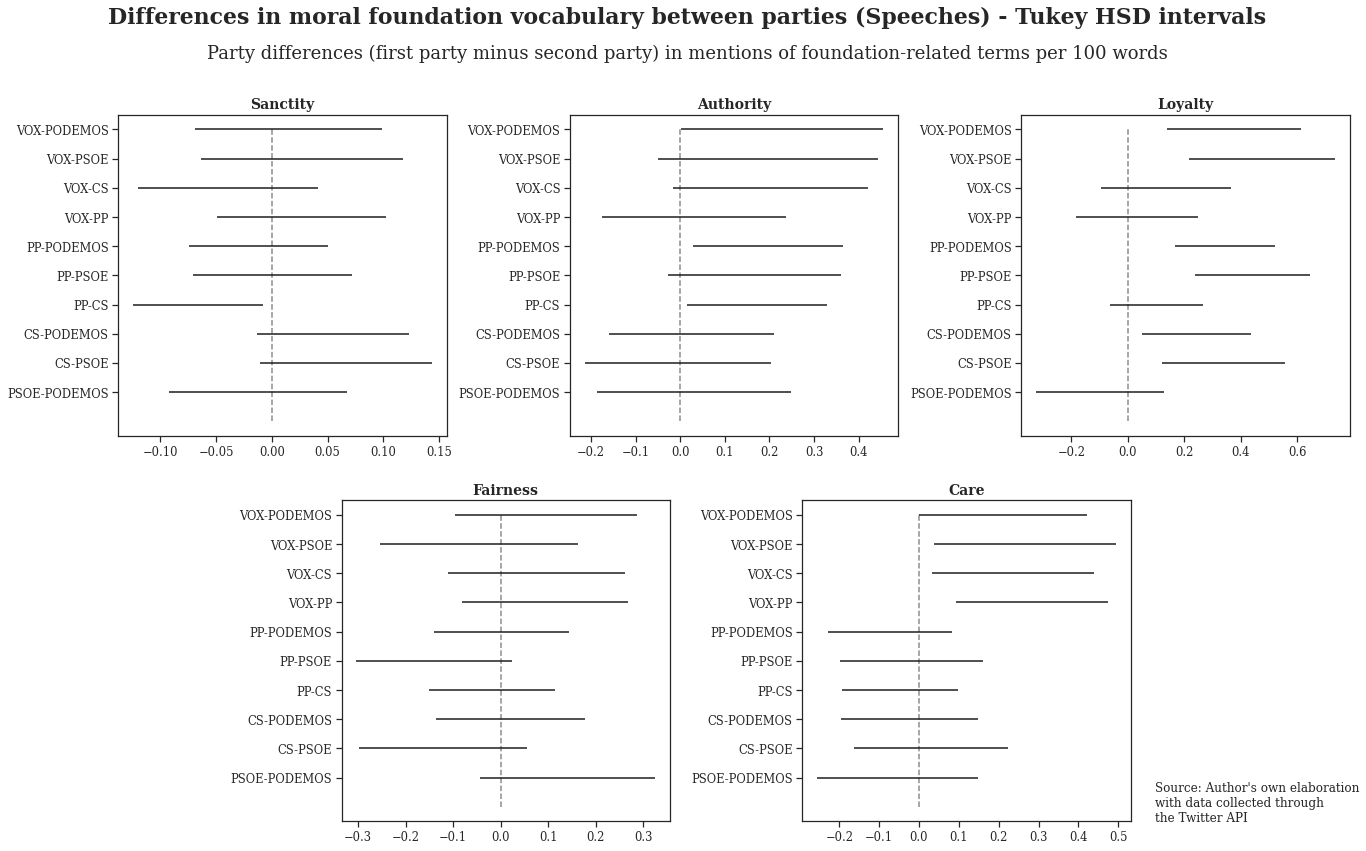

In [24]:
sns.set_style("ticks")
font = {'family' : 'serif'}
plt.rc('font', **font)

core_foundations = ['sanctity', 'authority', 'loyalty', 'fairness', 'care']
foundations_df = compare_diffs_plot(new_df, "speeches", return_dataset = True)

fig, axes = plt.subplots(2, 3, sharex = False, sharey = False, figsize = (20, 13))

text_type = "speeches"

# Create subplots only for 5 plots, eliminate the 6th one:
axes[1][2].set_visible(False)

go_right = 0.04
go_left = 0.02
go_up = -0.02

axes[0][0].set_position([0.125 - go_left, 0.5368181818181819 + go_up, 0.228, 0.343])
axes[0][1].set_position([0.3985294117647059 + go_right - go_left, 0.5368181818181819 + go_up,0.228,0.343])
axes[0][2].set_position([0.6720588235294118 + (go_right * 2) - go_left, 0.5368181818181819 + go_up,0.228,0.343])
axes[1][0].set_position([0.24 + go_right - go_left, 0.125 + go_up, 0.228, 0.343])
axes[1][1].set_position([0.56 + go_right - go_left, 0.125 + go_up, 0.228, 0.343])

# Set title and subtitle:
fig.text(s = f'Differences in moral foundation vocabulary between parties ({text_type.capitalize()}) - Tukey HSD intervals\n',
         x = 0.5, y = 0.95, fontsize = 22, ha = 'center', va = 'center', fontweight = "bold")

fig.text(s = 'Party differences (first party minus second party) in mentions of foundation-related terms per 100 words', x = 0.5, y = 0.925,
         fontsize = 18, ha = 'center', va = 'center')

for found_id in range(len(core_foundations)):
    col_nr = found_id
    # Determine the ax to plot
    if found_id <= 2:
        ax = axes[0][found_id]
        
    else:
        ax = axes[1][found_id - 3]
        
    # Calculate Tukey differences between groups and plot them
    foundation = core_foundations[found_id]
    tukey_comp = pairwise_tukeyhsd(endog  = foundations_df[foundation], 
                                   groups = foundations_df["party"],
                                   alpha  = 0.05)
    rows = clean_rows(tukey_comp.summary().data[1:])[::-1]
    ax.set_title(f'{foundation.capitalize()}', loc = 'center', 
                 fontsize = 14, fontweight = "bold")
    ax.hlines(range(len(rows)), [-row[5] for row in rows], [-row[4] for row in rows], color = 'k')
    ax.vlines(0, - 1, len(rows) - 1, linestyles = 'dashed', color = 'k', alpha = 0.5)
    
    # Format axes
    ax.set_yticks(range(len(rows)))
    ax.set_yticklabels([f'{x[0]}-{x[1]}' for x in rows])
    ax.xaxis.set_label(f'{foundation.capitalize()} mentions per 100 words')
    
    ax.yaxis.set_tick_params(labelsize = 11.5)
    ax.xaxis.set_tick_params(labelsize = 11.5)
    
# Set caption:
txt = "Source: Author's own elaboration\nwith data collected through\nthe Twitter API"
fig.text(0.825, 0.125, txt, fontsize = 12,
         ha = 'left', va = 'center')
    

    
plt.show();

#fig.savefig(f'plots/tukey_intervals_{text_type}.jpeg')


The main results of the analysis on **speeches** are a bit sensitive to the exclusion of dangerous words:

    1) The hypothesis on the authority foundation being mentioned more often by right than left parties is never rejected for the right party (PP) and all other parties to its left. Nevertheless, these results are sensitive to the exclusion of certain words for the far-right party (VOX). 
    None of the other results are sensitive.
    2) VOX, PP, and Cs use more the loyalty foundation than left parties (PODEMOS, PSOE)
    3) There are no big differences either in terms of fairness and care. Care is equal between all parties except for VOX, which uses it way more than the two big parties (PP and PSOE).
    4) There is no evidence for supporting the use of more sanctity words by right parties, although Cs was the party that used it more.

# THE CONTENT INCLUDED IN THE PAPER ENDS HERE

---

---

---

---

---

---

---

# THIS LAST SECTION OF THE REPO INCLUDES A PRELIMINARY ANALYSIS OF ASSOCIATIONS BETWEEN MORAL CONTENT AND POPULARITY OF TWEETS AS A BASIS FOR FUTURE RESEARCH, BUT IT IS NOT PART OF THE CONTENT OF THE PAPER

- Effect of moral vocabulary on popularity of tweets

In [114]:
original_tweets = pd.read_csv("../data/clean/tweets_df.csv")

# Create a measure of popularity, where retweets are more important than favorites
# Since they can extend beyond the total amount of followers more than favorites
# https://medium.com/@Encore/favorites-vs-retweets-and-why-one-is-more-important-than-the-other-ba12ee20e9ba
original_tweets["popularity"] = original_tweets.favorite_count * (1/3) + original_tweets.retweet_count * (2/3)
original_tweets["popularity_log"] = np.log(original_tweets.popularity + 1e-4)
original_tweets["favorite_count_log"] = np.log(original_tweets.favorite_count + 1e-4)

relevant_cols = ['status_id', 'screen_name', 'has_https', 'has_video', 'popularity', 
                 'popularity_log', 'favorite_count', 'favorite_count_log']
original_tweets = original_tweets[relevant_cols]

# Include moral counts in tweets:
moral_tweets_df = pd.read_csv("../data/clean/counts_text.csv")
counts_tweets = compare_diffs_plot(moral_tweets_df, "tweets", return_dataset = True)

counts_tweets = counts_tweets.rename(columns = {col: f'{col}_tweet' for col in counts_tweets.columns})
counts_tweets = counts_tweets.drop(['party_tweet'], axis = 1)

# Merge with the original tweets:
original_tweets = original_tweets.merge(counts_tweets, how = 'left', left_index = True, right_index = True)

# ---
# ---
# Include also moral counts in videos: 
counts_speech = compare_diffs_plot(moral_df, "speeches", return_dataset = True)
# Include status id of each speech
counts_speech = counts_speech.merge(moral_df.status_id, left_index = True, right_index = True)

# Merge the foundations values with the original tweets:
# Set a name for columns to differentiate them from the moral counts in tweets:
counts_speech = counts_speech.rename(columns = {col: f'{col}_speech' for col in counts_speech.columns})

# Merge with the original tweets:
original_tweets = original_tweets.merge(counts_speech, how = 'left',
                                        left_on = "status_id", right_on = "status_id_speech")

original_tweets = original_tweets.drop(["status_id_speech"], axis = 1)

In [115]:
original_tweets["total_moral_freq_tweets"] = original_tweets[[f'{foundation}_tweet' for foundation in core_foundations]].apply(sum, axis = 1)
original_tweets["total_moral_freq_speech"] = original_tweets[[f'{foundation}_speech' for foundation in core_foundations]].apply(sum, axis = 1)
original_tweets["total_moral_freq"] = original_tweets[[col for col in original_tweets.columns if col.split("_")[0] in core_foundations]].apply(sum, axis = 1)

In [116]:
original_tweets

,status_id,screen_name,has_https,has_video,popularity,popularity_log,favorite_count,favorite_count_log,sanctity_tweet,authority_tweet,loyalty_tweet,fairness_tweet,care_tweet,party_speech,sanctity_speech,authority_speech,loyalty_speech,fairness_speech,care_speech,total_moral_freq_tweets,total_moral_freq_speech,total_moral_freq
0,1192938088672174081,Santi_ABASCAL,True,True,6135.000000,8.721765,10925,9.298809,0.000000,0.000000,10.416667,2.083333,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,12.500000,NaN,NaN
1,1192933989180416002,Santi_ABASCAL,True,False,13350.000000,9.499272,24052,10.087973,1.612903,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.612903,NaN,NaN
2,1192933559255867392,Santi_ABASCAL,False,False,0.000000,-9.210340,0,-9.210340,0.000000,0.000000,1.388889,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.388889,NaN,NaN
3,1192928916173930496,Santi_ABASCAL,True,False,889.666667,6.790847,1559,7.351800,0.000000,1.428571,5.714286,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,7.142857,NaN,NaN
4,1192921331429511168,Santi_ABASCAL,True,True,2078.333333,7.639322,3575,8.181720,0.000000,1.086957,7.608696,1.086957,1.086957,VOX,0.0,0.609756,3.963415,0.609756,0.609756,10.869565,5.792683,16.662248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843,1191447353376550914,PODEMOS,True,False,0.000000,-9.210340,0,-9.210340,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2844,1191445946963501056,PODEMOS,True,True,184.666667,5.218553,246,5.505332,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2845,1191442719605960705,PODEMOS,True,True,1466.666667,7.290748,2438,7.798933,0.000000,0.000000,0.000000,0.000000,0.000000,PODEMOS,0.0,0.515464,0.515464,0.000000,1.030928,0.000000,2.061856,2.061856
2846,1191437590651645954,PODEMOS,True,False,0.000000,-9.210340,0,-9.210340,0.000000,3.846154,0.000000,1.923077,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.769231,NaN,NaN


Check relationship only of tweets with speeches: 

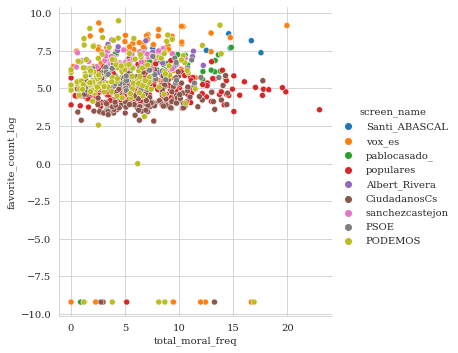

In [118]:
sns.relplot(x = "total_moral_freq", y = "favorite_count_log", 
            hue = "screen_name", data = original_tweets[original_tweets.total_moral_freq.notnull()]);

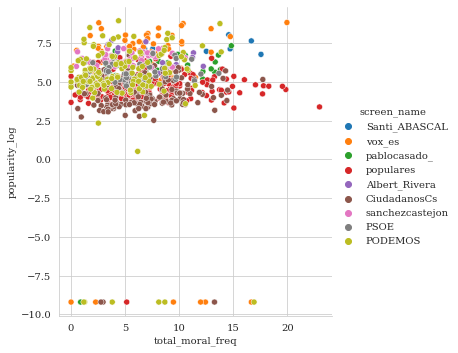

In [119]:
sns.relplot(x = "total_moral_freq", y = "popularity_log", 
            hue = "screen_name", data = original_tweets[original_tweets.total_moral_freq.notnull()]);

Linear regression

In [91]:
import statsmodels.formula.api as smf

In [120]:
est = smf.ols(formula = 'favorite_count_log ~ C(screen_name) * total_moral_freq', 
              data = original_tweets[original_tweets.total_moral_freq.notnull()]).fit()

In [121]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     favorite_count_log   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     5.364
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           2.28e-11
Time:                        14:06:10   Log-Likelihood:                -1737.0
No. Observations:                 757   AIC:                             3510.
Df Residuals:                     739   BIC:                             3593.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              7.6665      1.468      5.221      0.000       4.784      10.549
C(screen_name)[T.CiudadanosCs]                        -3.6540      1.535     -2.381      0.018      -6.667      -0.641
C(screen_name)[T.PODEMOS]                             -2.1303      1.510     -1.410      0.159      -5.096       0.835
C(screen_name)[T.PSOE]                                -2.0793      1.636     -1.271      0.204      -5.292       1.133
C(screen_name)[T.Santi_ABASCAL]                       -0.1261      3.200     -0.039      0.969      -6.408       6.156
C(screen_name)[T.pablocasado_]                        -3.0008      1.657     -1.811      0.071      -6.253       0.252
C(screen_name)[T.populares]                           -2.8763      1.500     -1.917      0.056      -5.821       0.069
C(screen_name)[T.sanchezcastejon]                     -0.8681      1.725     -0.503      0.615      -4.254       2.518
C(screen_name)[T.vox_es]                              -0.9362      1.579     -0.593      0.553      -4.035       2.163
total_moral_freq                                      -0.0861      0.190     -0.453      0.651      -0.459       0.287
C(screen_name)[T.CiudadanosCs]:total_moral_freq        0.1198      0.199      0.602      0.548      -0.271       0.510
C(screen_name)[T.PODEMOS]:total_moral_freq             0.0374      0.200      0.187      0.852      -0.355       0.430
C(screen_name)[T.PSOE]:total_moral_freq                0.1212      0.220      0.550      0.582      -0.311       0.554
C(screen_name)[T.Santi_ABASCAL]:total_moral_freq       0.1079      0.290      0.372      0.710      -0.461       0.677
C(screen_name)[T.pablocasado_]:total_moral_freq        0.2697      0.213      1.267      0.206      -0.148       0.688
C(screen_name)[T.populares]:total_moral_freq           0.0972      0.194      0.501      0.617      -0.284       0.478
C(screen_name)[T.sanchezcastejon]:total_moral_freq     0.1090      0.241      0.452      0.651      -0.364       0.582
C(screen_name)[T.vox_es]:total_moral_freq             -0.0276      0.204     -0.135      0.893      -0.428       0.373
==============================================================================
Omnibus:                      753.458   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25137.545
Skew:                          -4.742   Prob(JB):                         0.00
Kurtosis:                      29.590   Cond. No.                         427.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

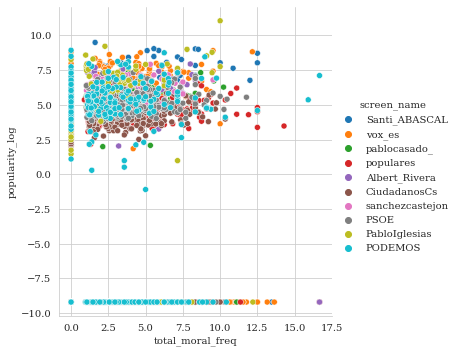

In [63]:
sns.relplot(x = "total_moral_freq", y = "popularity_log", 
            hue = "screen_name", data = original_tweets);

In [26]:
a = pd.read_csv("../data/clean/tweets_df.csv")

In [ ]:
a.value_counts("party")

party
PODEMOS    659
PP         583
PSOE       579
CS         540
VOX        487
dtype: int64

In [ ]:
a.shape[0]

2848

In [28]:
b = pd.read_csv("../data/raw/transcriptions_df.csv")

In [35]:
b.merge(a.loc[:, ["status_id", "party"]], on = "status_id").value_counts("party")

party
PP         302
CS         213
PODEMOS    152
VOX        140
PSOE       115
dtype: int64

In [39]:
b.shape[0]

922

In [36]:
c = pd.read_csv("../data/clean/transcriptions_df.csv")

In [37]:
c.value_counts("party")

party
PP         276
CS         170
PODEMOS    138
PSOE        93
VOX         80
dtype: int64

In [40]:
c.shape[0]

757